By Akinde Kadjo

# Introduction

Antimicrobial resistance (AMR) occurs when an organism (bacteria, microbe etc. ) is or evolve to be resistant to an antibiotic. Microbes resistant to multiple antimicrobials are called multidrug resistant (MDR) and are sometimes referred to as superbugs.

The goal of this project is to predict species AMR using their MS spectra. The Data used here was collected from the University Hospital of Basel, Switzerland and downloaded from [Kaggle](https://www.kaggle.com/datasets/drscarlat/driams/data). 
One of the publications ([link](https://www.biorxiv.org/content/10.1101/2020.07.30.228411v2)) using this same data, treats it as a multi-classification problem. 

My approach here is to treat is a regression problem where the labels for each antibiotic is converted into an overall antibiotic resistance score.

The image below (taken from [wikipedia](https://en.wikipedia.org/wiki/Antimicrobial_resistance) ) shows the bacteria on the right being resistant to 3 of the 7 antibiotics (white rings) while the bacteria on the left is sensitive to all of the 7 antibiotics.

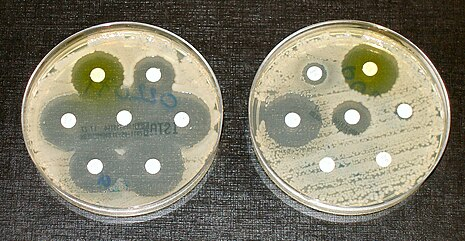

In [1]:
from IPython.display import Image, display
display(Image(filename='image.jpg', embed=True))

# Data Pre-processing

The original data size is very large over 20 GB, so it won't be added to this GitHub directory but can be found at this link [here.](https://www.kaggle.com/datasets/drscarlat/driams) 
Only the DRIAMS-A folder is used for our analysis.

By preprocessing the data, the size was reduced to about 300 MB.

## MS data preprocessing

The ipynb file can be found [here.](https://github.com/AkindeKadjo/MALDI-TOF_Mass_Spectra_Resistance_to_Antibiotics/blob/main/ms_data_processing.ipynb)

The provided MALDI-TOF mass spectra are stored in a *.txt* format that have been binned along the mass-to-charge-ratio axis with a bin size of 3Da, resulting in 6000 feature bins.
My preprocessing steps consisted of: selecting only the binned data column from each *.txt* file, normalizing it to a maximum of 1, removing the noise by keeping data points above 5%, saving the data as float 16 for less memory, keeping the filename as in the id column, combining all of the data in a single dataframe and saving it as a single compressed file.

## Label data preprocessing

The ipynb file can be found [here.](https://github.com/AkindeKadjo/MALDI-TOF_Mass_Spectra_Resistance_to_Antibiotics/blob/main/labels_data_processing.ipynb)

The provided labeled data are provided in a *.csv* format. In other words, this is the AMR (Antimicrobial resistance) susceptibility profile sheet, containing the code, species and antibiotic list, where R are listed for 'resistant' and S for 'sensitive'. My preprocessing steps consisted of: concateneting all 4 different files, removing unnecessary columns (i.e unnamed) and empty columns, combining all 4 files into a single Dataframe,  removing the duplicate species column, correcting the 'species' column for miss spelling, and saving it as a single compressed file.

# Imports

In [2]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

import lazypredict
from lazypredict.Supervised import LazyRegressor

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
##MS Data into one DataFrame
df2015 = pd.read_csv('ms_2015.csv.gz',  sep=',', low_memory=False)
df2016 = pd.read_csv('ms_2016.csv.gz',  sep=',', low_memory=False)
df2017 = pd.read_csv('ms_2017.csv.gz',  sep=',', low_memory=False)
df2018 = pd.read_csv('ms_2018.csv.gz',  sep=',', low_memory=False)

#combining all data
ms_df = pd.concat([df2015,df2016,df2017,df2018])
print(f'MS df shape {ms_df.shape}')

MS df shape (111257, 6001)


In [4]:
label_df = pd.read_csv('labels.csv.gz',  sep=',', low_memory=False)
print(f'label df shape {label_df.shape}')

label df shape (111257, 84)


# Visualization

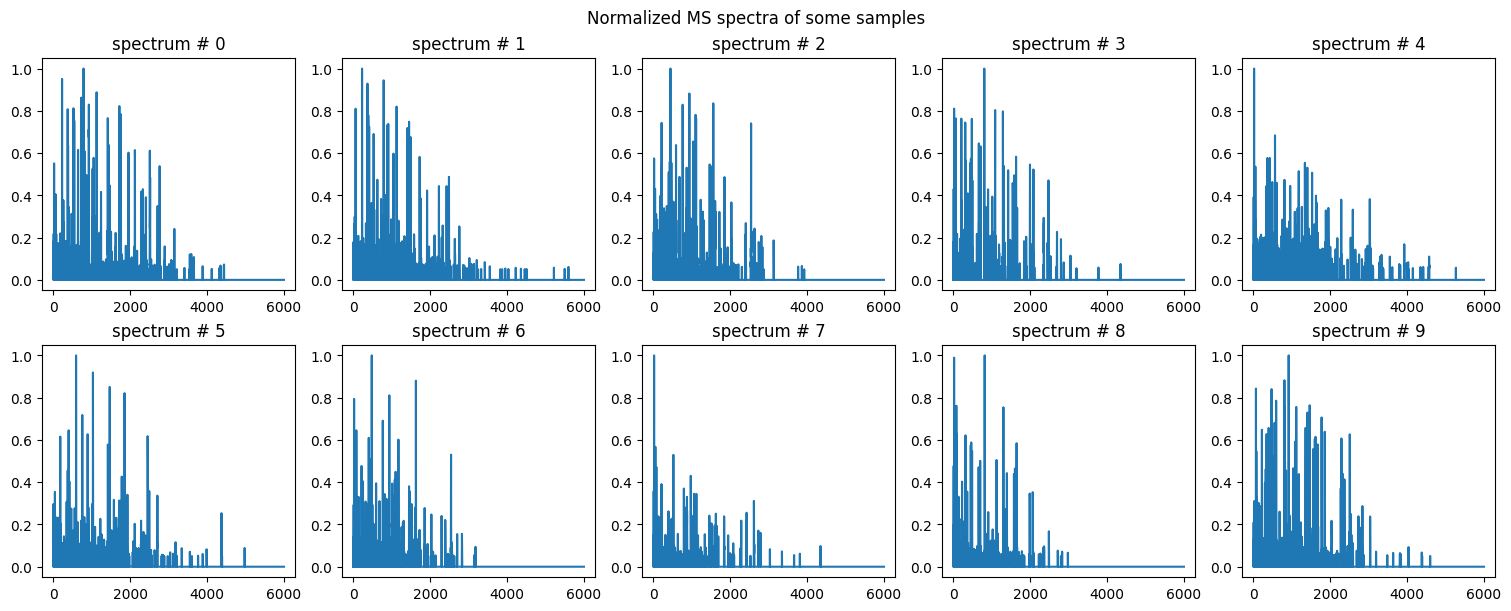

In [5]:
#let's plot the first 10 spectra
fig, axes = plt.subplots(2,5, figsize = (15, 6),constrained_layout=True)
fig.suptitle("Normalized MS spectra of some samples")
axes = axes.ravel()
for i in range(10):
    axes[i].plot(list(df2015.iloc[i][1:]))
    axes[i].set_title(f'spectrum # {i}')
plt.show()

# Data Cleaning

Antimicrobial resistance are reported as resistant (R), intermediate (I) and susceptible (S).

In [15]:
#overview of entered values
x = label_df.drop(columns =['code', 'species'])
x.apply(pd.Series.value_counts)

,Piperacillin-Tazobactam,Meropenem,Ciprofloxacin,Cefepime,Cotrimoxazole,Ceftazidime,Amikacin,Levofloxacin,Imipenem,Tobramycin,...,Teicoplanin_GRD,Ceftarolin,Penicillin_without_meningitis,Cefuroxime.1,Ceftazidime-Avibactam,Ceftolozane-Tazobactam,Ampicillin-Sulbactam,Ceftobiprole,Strepomycin_high_level,Isavuconazole
I,403,314.00,711,960,27.00,567.00,759.00,404.00,1160.00,56.00,...,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN
"I(1), S(1)",36,52.00,77,53,11.00,82.00,175.00,61.00,66.00,11.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R,6143,4831.00,6751,5558,4845.00,1888.00,216.00,3569.00,5712.00,1639.00,...,2.00,10.00,NaN,NaN,15.00,35.00,11.00,38.00,NaN,1.00
"R(1), I(1)",19,32.00,38,92,NaN,78.00,12.00,48.00,37.00,7.00,...,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN
"R(1), I(1), S(1)",1,NaN,7,2,NaN,NaN,NaN,4.00,2.00,3.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"R(1), S(1)",344,170.00,247,234,391.00,132.00,20.00,114.00,198.00,85.00,...,NaN,NaN,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN
R(2),2,2.00,4,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S,21852,24386.00,23081,21958,21768.00,14937.00,16247.00,16811.00,22519.00,16495.00,...,10.00,27.00,4.00,3.00,56.00,72.00,3.00,24.00,4.00,4.00
S(2),2,4.00,4,4,NaN,4.00,4.00,4.00,4.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since I'm treating this AMR prediction as a regression, I'll come up with an AMR Index. R = 3, I = 2, S = 1, I(1)S(1) = 1.5, R(1)I(1) = 2.5, R(1)I(1)S(1) = 2, R(1)S(1) = 2, R(2) = 3.5, S(2) = 0.5. These are arbitrary values assigned by me with the highest score indicating the organism with the highest resistance. The AMR Index will be the sum of each antibiotic AMR value.

In [24]:
x = x.replace('\\n', '', regex=True)
x_values = x.replace(['R(2)','R',"R(1), I(1)",'I','R(1), I(1), S(1)','R(1), S(1)','I(1), S(1)','S','S(2)', np.nan],
                     [3.5,3,2.5, 2,2,2,1.5,1,0.5, 0])
x_values.apply(pd.Series.value_counts)

,Piperacillin-Tazobactam,Meropenem,Ciprofloxacin,Cefepime,Cotrimoxazole,Ceftazidime,Amikacin,Levofloxacin,Imipenem,Tobramycin,...,Teicoplanin_GRD,Ceftarolin,Penicillin_without_meningitis,Cefuroxime.1,Ceftazidime-Avibactam,Ceftolozane-Tazobactam,Ampicillin-Sulbactam,Ceftobiprole,Strepomycin_high_level,Isavuconazole
0.00,82455,81466,80337,82394,84215.00,93569.00,93824.00,90242.00,81559.00,92953.00,...,111245.00,111220.00,111253.00,111252.00,111180.00,111150.00,111243.00,111195.00,111253.00,111252.00
0.50,2,4,4,4,NaN,4.00,4.00,4.00,4.00,8.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.00,21852,24386,23081,21958,21768.00,14937.00,16247.00,16811.00,22519.00,16495.00,...,10.00,27.00,4.00,3.00,56.00,72.00,3.00,24.00,4.00,4.00
1.50,36,52,77,53,11.00,82.00,175.00,61.00,66.00,11.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.00,748,484,965,1196,418.00,699.00,779.00,522.00,1360.00,144.00,...,NaN,NaN,NaN,NaN,6.00,NaN,NaN,NaN,NaN,NaN
2.50,19,32,38,92,NaN,78.00,12.00,48.00,37.00,7.00,...,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN
3.00,6143,4831,6751,5558,4845.00,1888.00,216.00,3569.00,5712.00,1639.00,...,2.00,10.00,NaN,NaN,15.00,35.00,11.00,38.00,NaN,1.00
3.50,2,2,4,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
label_df['AMR_Index'] = x_values.sum(axis=1)
amr_label = label_df[['code','AMR_Index']]
amr_label.head()

,code,AMR_Index
0,8d1fdc59-4614-4af7-ae96-25a38a714b0b,6.00
1,9f20c137-1706-447c-9ea6-0a450bf42e90_MALDI1,0.00
2,0b2ac6e5-764f-4f17-bbb5-c651cf249d77_MALDI1,0.00
3,b1575a63-50d3-4a1a-847c-a9d17986f2cb_MALDI2,3.00
4,a32e6bb1-ae48-45d0-98a2-ec611c0ecbfe_MALDI1,4.00


For some of these samples, no AMR info was entered, therefore leading to my calculated AMR_Index of 0. I'll remove these samples for better data analysis.

In [28]:
#removing 
print(f'amr_label shape before cleaning {amr_label.shape}')
amr_label= amr_label.loc[amr_label['AMR_Index'] > 0]
print(f'amr_label shape after cleaning {amr_label.shape}')

amr_label shape before cleaning (111257, 2)
amr_label shape after cleaning (38342, 2)


In [29]:
amr_label.head()

,code,AMR_Index
0,8d1fdc59-4614-4af7-ae96-25a38a714b0b,6.00
3,b1575a63-50d3-4a1a-847c-a9d17986f2cb_MALDI2,3.00
4,a32e6bb1-ae48-45d0-98a2-ec611c0ecbfe_MALDI1,4.00
5,1444b079-3ba4-46ca-a8b3-5b88a32c5c0c_MALDI2,3.00
6,980850f0-8c98-459b-a721-188db47a541c_MALDI2,3.00


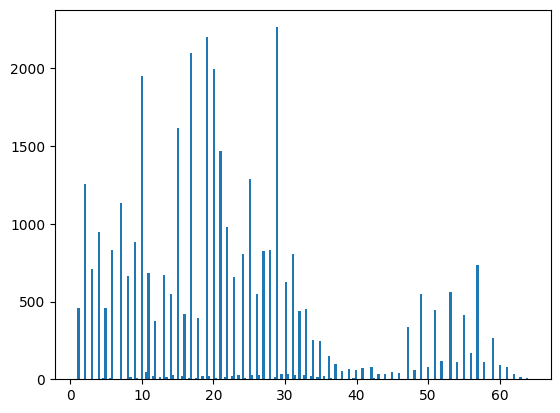

In [35]:
# a quick look at the AMR_Index distribution
plt.hist(amr_label['AMR_Index'], bins = 200)
plt.show()

It seems like the majority of samples have AMR_Indexes below 30

In [30]:
newms_df = ms_df.merge(amr_label, left_on='id', right_on='code',how='inner')
print(newms_df.shape)
newms_df.head()

(38342, 6003)


,id,bin0,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,...,bin5992,bin5993,bin5994,bin5995,bin5996,bin5997,bin5998,bin5999,code,AMR_Index
0,002c93f2-36f2-407a-8aa4-a077af7be519,0.13,0.12,0.06,0.08,0.08,0.12,0.07,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,002c93f2-36f2-407a-8aa4-a077af7be519,52.00
1,009c37b7-f8db-4504-a891-e4cad18d56d8,0.06,0.11,0.05,0.00,0.09,0.06,0.06,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,009c37b7-f8db-4504-a891-e4cad18d56d8,9.00
2,011fcbf7-7b7f-40a8-a569-9e30bd41e59d,0.07,0.06,0.00,0.07,0.15,0.10,0.05,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,011fcbf7-7b7f-40a8-a569-9e30bd41e59d,17.00
3,01ae0629-b9b5-41ac-a712-37f45e5a7b2c,0.08,0.08,0.00,0.00,0.00,0.08,0.08,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,01ae0629-b9b5-41ac-a712-37f45e5a7b2c,9.00
4,01af95b5-2abd-4850-8a0d-414360c43f59,0.00,0.07,0.06,0.06,0.10,0.10,0.08,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,01af95b5-2abd-4850-8a0d-414360c43f59,30.00


In [37]:
#saving the new dataframe for further analyses
newms_df.to_csv('compact_data.csv.gz', index=False, compression='gzip')

# ML Prediction

In [ ]:
newms_df = newms_df.drop(columns=['code'])

# Conclusion